In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

# set visulization style
sns.set_style(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')



In [ ]:

# --- Ensure consistent working directory for data loading ---
# This block dynamically sets the current working directory to the Git repository root.
# This makes data paths reliable for all collaborators, regardless of where they open the notebook.

current_dir = os.getcwd()
repo_root = current_dir
while not os.path.exists(os.path.join(repo_root, '.git')):
    # Move up one directory
    parent_dir = os.path.dirname(repo_root)
    if parent_dir == repo_root: # Reached filesystem root, .git not found
        raise FileNotFoundError(
            "Could not find the .git directory. "
            "Please ensure you are running this code from within a Git repository."
        )
    repo_root = parent_dir

# Change the current working directory if it's not already the repo root
if os.getcwd() != repo_root:
    os.chdir(repo_root)
    print(f"Working directory set to: {os.getcwd()}") # Informative print for users


# --- Data Loading ---
# Path to the data file, relative to the repository root.
data_file_name = 'Customer_Purchasing_Behaviors.csv'
data_file_path = os.path.join('data', 'raw', data_file_name)

try:
    df = pd.read_csv(data_file_path)
    print(f"Successfully loaded '{data_file_name}'.")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{data_file_name}' was not found at '{data_file_path}'.")
    print("Please ensure it exists in the 'data/raw/' folder relative to the repository root.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Successfully loaded 'Customer_Purchasing_Behaviors.csv'.
   user_id  age  annual_income  purchase_amount  loyalty_score region  \
0        1   25          45000              200            4.5  North   
1        2   34          55000              350            7.0  South   
2        3   45          65000              500            8.0   West   
3        4   22          30000              150            3.0   East   
4        5   29          47000              220            4.8  North   

   purchase_frequency  
0                  12  
1                  18  
2                  22  
3                  10  
4                  13  


Initial observations:
-East region heavily under represented
-no data for incomes ~$32-42K

In [14]:
print("\nData Info")
df.info()




Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             238 non-null    int64  
 1   age                 238 non-null    int64  
 2   annual_income       238 non-null    int64  
 3   purchase_amount     238 non-null    int64  
 4   loyalty_score       238 non-null    float64
 5   region              238 non-null    object 
 6   purchase_frequency  238 non-null    int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 13.1+ KB


In [15]:
print("\nMissing Values")
print(df.isnull().sum())




Missing Values
user_id               0
age                   0
annual_income         0
purchase_amount       0
loyalty_score         0
region                0
purchase_frequency    0
dtype: int64


In [16]:
print("\nStatistical Summary")
print(df.describe())




Statistical Summary
          user_id         age  annual_income  purchase_amount  loyalty_score  \
count  238.000000  238.000000     238.000000       238.000000     238.000000   
mean   119.500000   38.676471   57407.563025       425.630252       6.794118   
std     68.848868    9.351118   11403.875717       140.052062       1.899047   
min      1.000000   22.000000   30000.000000       150.000000       3.000000   
25%     60.250000   31.000000   50000.000000       320.000000       5.500000   
50%    119.500000   39.000000   59000.000000       440.000000       7.000000   
75%    178.750000   46.750000   66750.000000       527.500000       8.275000   
max    238.000000   55.000000   75000.000000       640.000000       9.500000   

       purchase_frequency  
count          238.000000  
mean            19.798319  
std              4.562884  
min             10.000000  
25%             17.000000  
50%             20.000000  
75%             23.000000  
max             28.000000  


In [17]:
df.columns

Index(['user_id', 'age', 'annual_income', 'purchase_amount', 'loyalty_score',
       'region', 'purchase_frequency'],
      dtype='object')

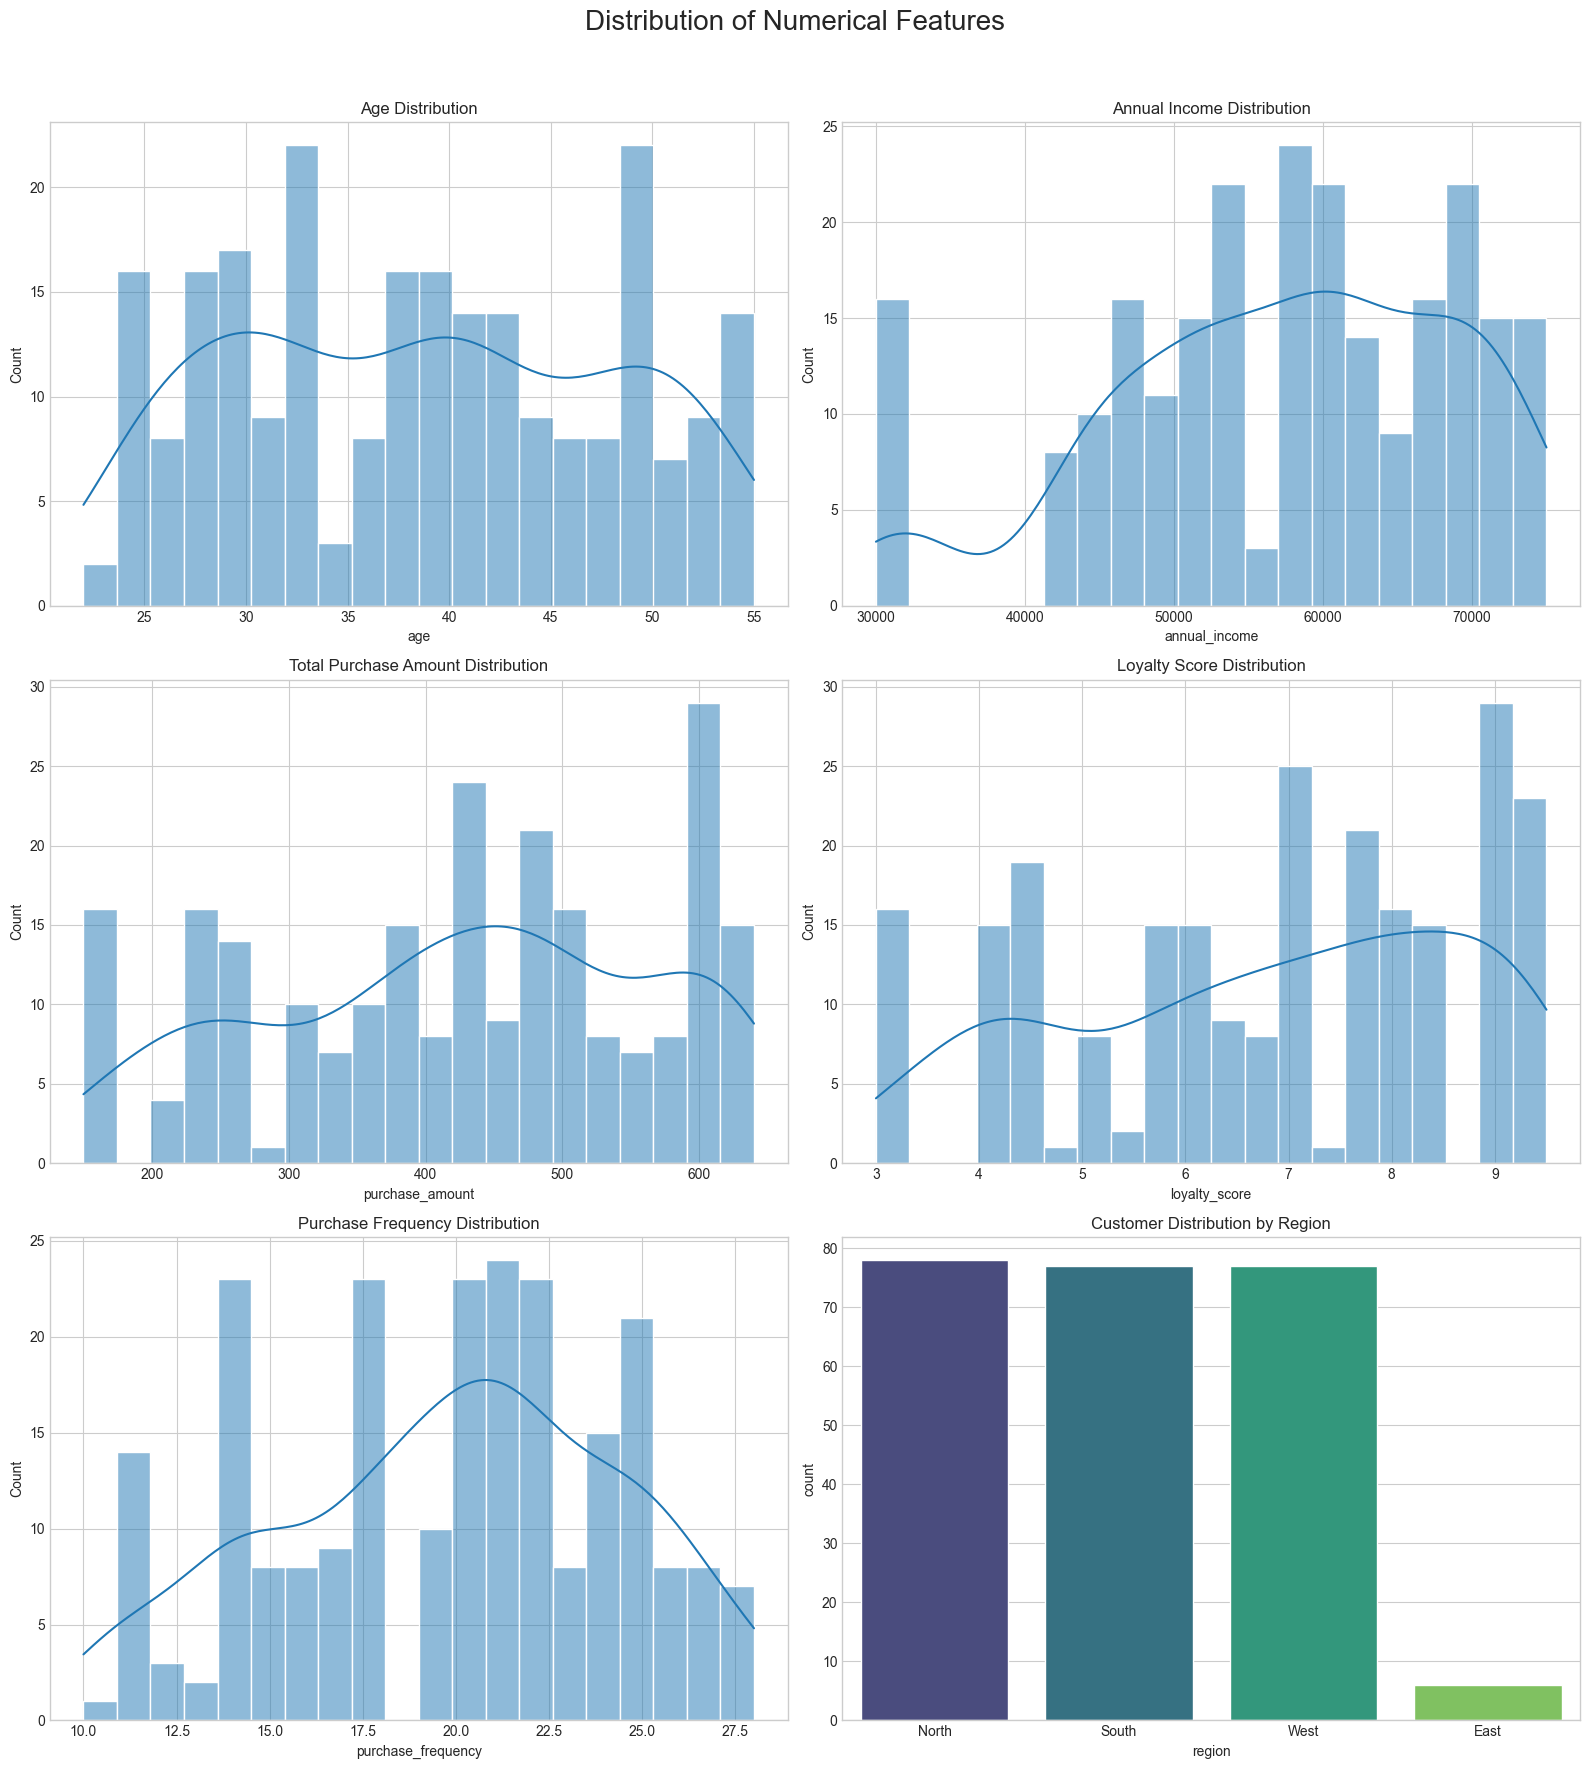

In [18]:
# Create a figure for subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Distribution of Numerical Features', fontsize=20)

# Age Distribution
sns.histplot(df['age'], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution')

# Annual Income Distribution
sns.histplot(df['annual_income'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Annual Income Distribution')

# Purchase Amount Distribution
sns.histplot(df['purchase_amount'], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Total Purchase Amount Distribution')

# Loyalty Score Distribution
sns.histplot(df['loyalty_score'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Loyalty Score Distribution')

# Purchase Frequency Distribution
sns.histplot(df['purchase_frequency'], bins=20, kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Purchase Frequency Distribution')

# Regional Distribution
sns.countplot(data=df, x='region', ax=axes[2, 1], hue='region', palette='viridis')
axes[2, 1].set_title('Customer Distribution by Region')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Understanding Feature Distributions by Univariate Analysis

**Key Observations:**

*   **Multimodal Distributions:** Several features, notably `age`, `annual_income`, and `purchase_amount`, exhibit multimodal distributions (having multiple peaks). This is a strong indicator that there are likely 2-3 distinct subgroups of customers within the dataset. For instance, the peaks in `age` around 30 and 50 could represent different life-stage segments.

*   **Narrow Ranges:** The `loyalty_score` (3.0 to 9.5) and `purchase_frequency` (10 to 28) exist within surprisingly narrow bands. This is uncharacteristic of real-world data and points towards the dataset being synthetic. 

*   **Categorical Feature:** The `region` feature is balanced across North, South, and West but the East is highly underrepresented, any predictions for customers in the "East" region are likely to have high uncertainty. Small sample size means this average could be wildly inaccurate and not representative of the true "East" population. 

**Implication for Modeling:**

The clear presence of multiple modes in the data strongly suggests that **unsupervised clustering (e.g., K-Means)** will be a highly effective technique for identifying these inherent customer segments. The East region being highly under represented, we could either acknowledge it proceed with caution or we could create a new feature `North_East`. 

In [19]:
# Making a copy of the dataframe
df_working = df.copy()

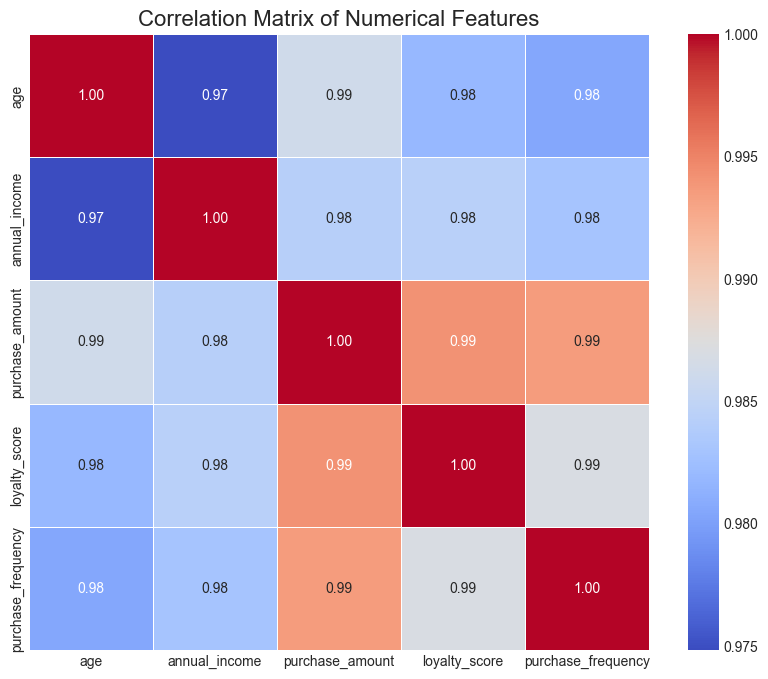

In [20]:
# Calculate the correlation matrix
corr_matrix = df_working.drop(['user_id', 'region'], axis=1).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

## Quantifying Linear Relationships through Bivariate Analysis

**Key Observations**

*   The heatmap shows correlation coefficients that are consistently **above 0.97** for all pairs of numerical features. This is an extreme level of multicollinearity, 
indicating that the features are not just related, but are nearly perfect linear combinations of each other. A key feature of synthetic data. 


**Implications for Modeling & Our Strategic Response:**

The extreme multicollinearity is the single most important factor guiding our modeling strategy. It dictates which models are appropriate and how we must interpret their results.

*   **For Linear Models (e.g., Linear/Logistic Regression): Complete Instability.**
    *   **Problem:** These models will be highly unstable. Multicollinearity makes it impossible for the model to decide how to assign credit. Think of it like two people writing a report together; you can't tell who wrote 90% and who wrote 10%. The model's coefficients will be mathematically unreliable and completely uninterpretable.
    *   **Our Action:** We will avoid using linear models for our final predictive task. We may, however, train one briefly to *demonstrate* this instability, showcasing our diagnostic skills.

*   **For Tree-Based Models (e.g., XGBoost): Predictive Accuracy vs. Interprtation**
    *   **Good News:** These models are robust in their predictive power. They will still make accurate predictions because they can simply pick one of the correlated features (e.g., `annual_income`) at each split and effectively learn the underlying patterns.
    *   **The Challenge:** The *interpretation* of feature importance (like SHAP values) requires nuance. The model will likely attribute all importance to the one feature it picked and assign zero importance to its correlated partners.
    *   **Our Interpretation Strategy:** We will interpret this correctly: not as "`annual_income` is the only important feature," but as "**`annual_income` is acting as the chosen representative for the entire 'customer value' signal**" that is shared across the correlated group.

*   **Our Overarching Action Plan: Disciplined Feature Management.**
    *   **Mandatory Feature Selection for Prediction:** For any *interpretable predictive model*, we will perform disciplined feature selection. We will select a minimal, non-redundant set of features (e.g., `age`, `annual_income`) that are most business-relevant to serve as inputs.
    *   **Leverage Redundancy for Segmentation:** For unsupervised clustering (K-Means), we can use all features. Here, the redundant information can actually help reinforce the cluster structures, making the segments more distinct.

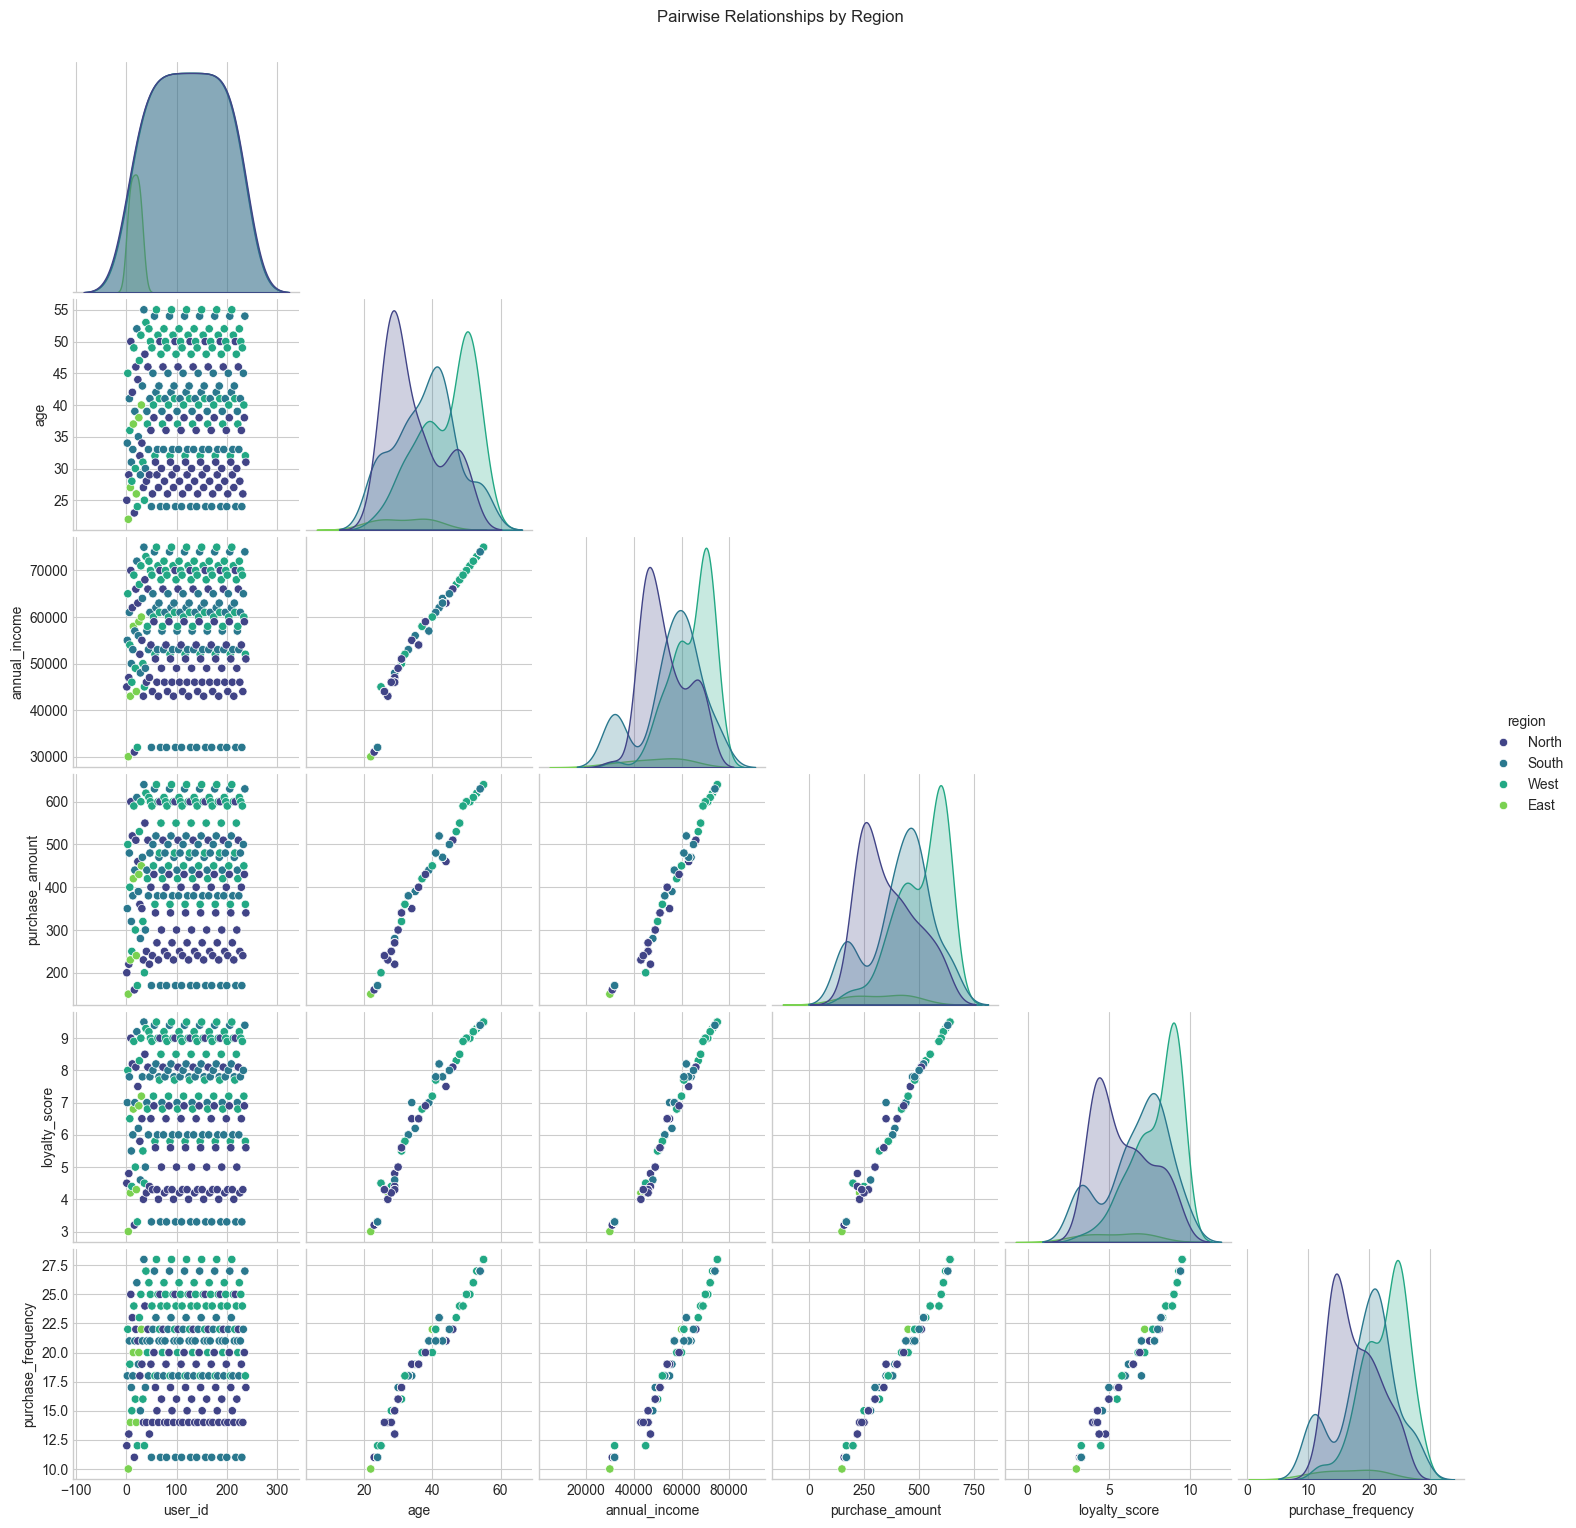

In [21]:
# Pairplot to see all bivariate relationships
# We use a sample to make it render faster if needed, but 238 rows is fine.
pair_plot = sns.pairplot(df_working, hue='region', palette='viridis', corner=True)
pair_plot.fig.suptitle('Pairwise Relationships by Region', y=1.02)
plt.show()

## Pairwise Relationships

**Key Observations:**

*   **Confirmation of Linearity:** The scatter plots confirm the extreme multicollinearity. The relationships are not just general trends; they form near-perfect straight lines. This is the most compelling visual evidence of the dataset's synthetic, formulaic origin.

*   **No Separation Among Dominant Regions:** The `hue` coloring shows that data points for the well-represented regions (**North, South, and West**) are completely mixed. This indicates that for ~90% of our customers, their region is not a meaningful differentiator of their behavior.

*   **No Obvious Non-Linearity:** There are no curved or complex patterns. The underlying relationships in this dataset are overwhelmingly linear.

**Implication for Modeling:**

*   **Low Predictive Power of `region`:** The feature has very little predictive power for the majority of the data.
*   **Handling the "East" Category:** This plot provides the visual justification for our strategy to handle the "East" category. We cannot trust the model to learn meaningful patterns from such a small sample. Therefore, grouping "East" into a combined category is the most robust approach to prevent the model from learning spurious, noise-driven rules.

### EDA Summary

**Our comprehensive Exploratory Data Analysis (EDA) has revealed that the dataset is highly synthetic and defined by two critical flaws:**

1. Extreme Multicollinearity: All numerical features are almost perfectly correlated (>0.97), making them informationally redundant.
2. Severe Class Imbalance: The "East" region is drastically underrepresented, making any statistical conclusions about it unreliable.

Instead of treating these as blockers, we are making them the centerpiece of our project. Our objective has shifted from simple prediction to a more sophisticated goal: to showcase a robust, end-to-end ML methodology for handling compromised, real-world-like data.

**Our possible action plan is:**

**Leverage the Data's Strengths:** Use the clear, linear structure for a powerful customer segmentation model using K-Means.

**Mitigate the Flaws for Prediction:** Use tree-based models with disciplined feature selection to create stable predictive models, avoiding the instability of linear approaches.

**Demonstrate Nuanced Interpretation:** Deliver a cautious interpretation of model results (especially feature importance), explaining how multicollinearity impacts them.

**Deliver a Proof-of-Concept:** Package our entire workflow—from diagnostics to deployment—into a functional Tableau or Streamlit dashboard that proves the value of a well-designed customer intelligence platform, even when built on imperfect data.

**EXTRA - TEMPORARY LOCATION**

Original dataset

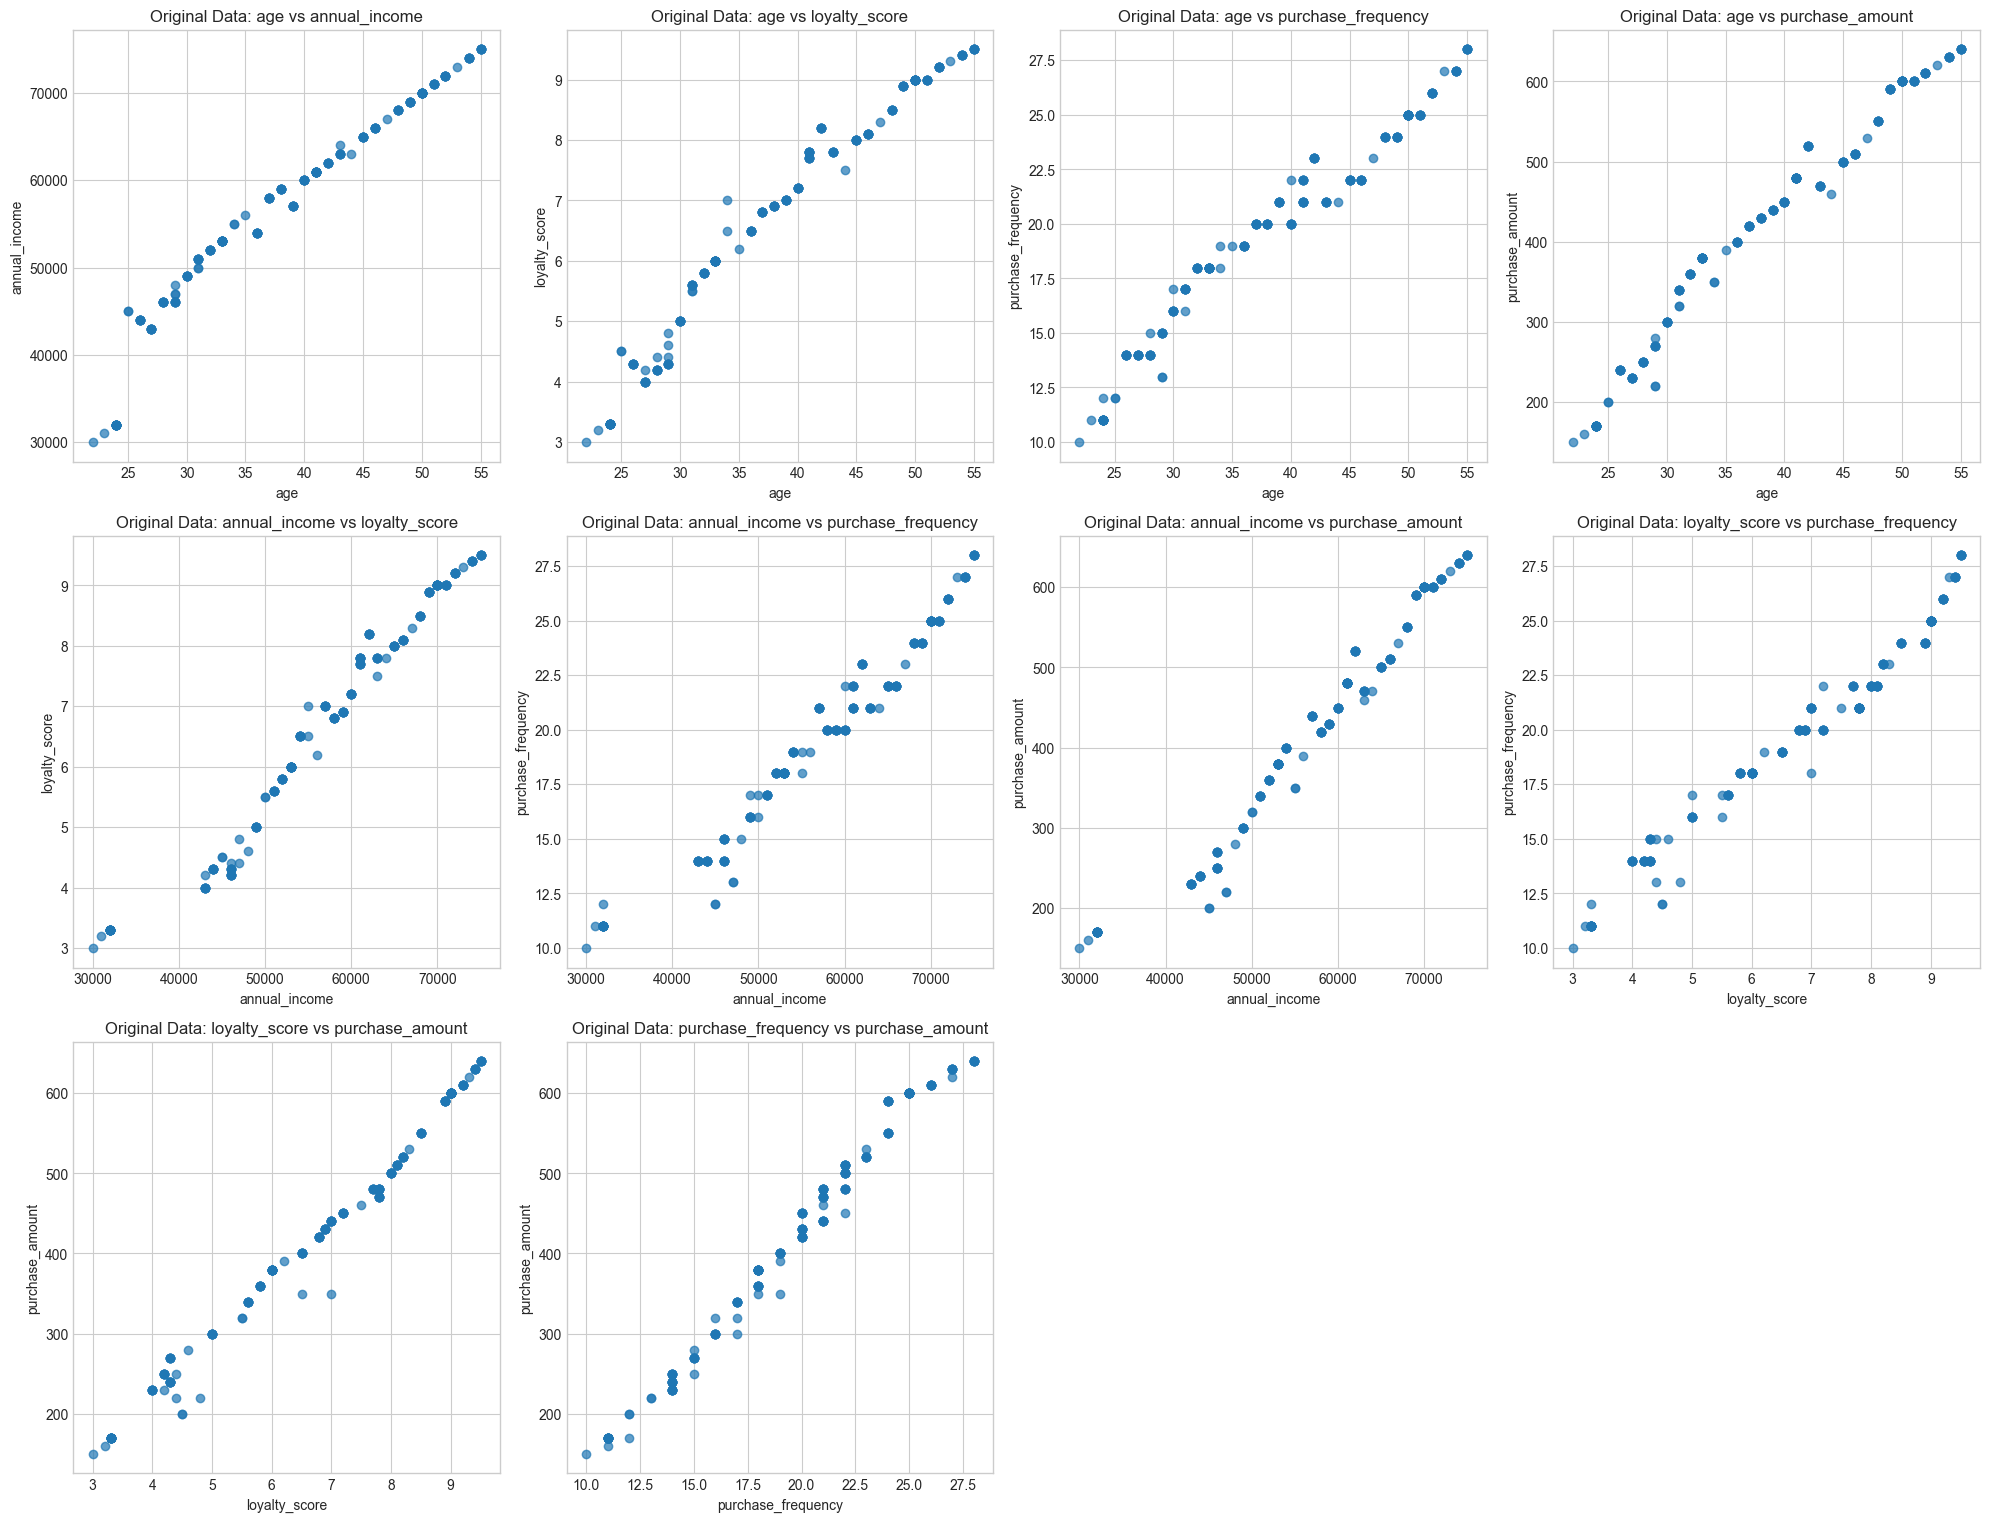

In [ ]:
# Let's plot the relationships to try to obtain inputs to decide what non-linear transformation to apply

def plot_feature_pairs(data, feature_names, color_labels=None, title_prefix=''):
    """
    Helper function to create scatter plots for all possible pairs of features.
    
    Parameters:
    - data: DataFrame containing the features to be plotted.
    - feature_names: List of feature names to be used in plotting.
    - color_labels: Optional. Cluster or class labels to color the scatter plots.
    - title_prefix: Optional. Prefix for plot titles to distinguish between different sets of plots.
    """
    # Create a figure for the scatter plots
    plt.figure(figsize=(20, 20))
    
    # Counter for subplot index
    plot_number = 1
    
    # Loop through each pair of features
    for i in range(len(feature_names)):
        for j in range(i + 1, len(feature_names)):
            plt.subplot(len(feature_names)-1, len(feature_names)-1, plot_number)
            
            # Scatter plot colored by labels if provided
            if color_labels is not None:
                plt.scatter(data[feature_names[i]], data[feature_names[j]], 
                            c=color_labels, cmap='viridis', alpha=0.7)
            else:
                plt.scatter(data[feature_names[i]], data[feature_names[j]], alpha=0.7)
            
            plt.xlabel(feature_names[i])
            plt.ylabel(feature_names[j])
            plt.title(f'{title_prefix}{feature_names[i]} vs {feature_names[j]}')
            
            # Increment the plot number
            plot_number += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()                  #________P_L_O_T________#

In [ ]:
# Get feature names
df_num = df[['age', 'annual_income', 'loyalty_score','purchase_frequency', 'purchase_amount']]
feature_names = df_num.columns

# Use the helper function to plot scatter plots without coloring by cluster labels
plot_feature_pairs(df, feature_names, title_prefix='Original Data: ')   

Features Engineered Dataset

In [32]:

# --- Ensure consistent working directory for data loading ---
# This block dynamically sets the current working directory to the Git repository root.
# This makes data paths reliable for all collaborators, regardless of where they open the notebook.

current_dir = os.getcwd()
repo_root = current_dir
while not os.path.exists(os.path.join(repo_root, '.git')):
    # Move up one directory
    parent_dir = os.path.dirname(repo_root)
    if parent_dir == repo_root: # Reached filesystem root, .git not found
        raise FileNotFoundError(
            "Could not find the .git directory. "
            "Please ensure you are running this code from within a Git repository."
        )
    repo_root = parent_dir

# Change the current working directory if it's not already the repo root
if os.getcwd() != repo_root:
    os.chdir(repo_root)
    print(f"Working directory set to: {os.getcwd()}") # Informative print for users


# --- Data Loading ---
# Path to the data file, relative to the repository root.
data_file_name = 'df_eng_customer_purchasing_features.csv'
data_file_path = os.path.join('data', 'processed', data_file_name)

try:
    df_feat_eng = pd.read_csv(data_file_path)
    print(f"Successfully loaded '{data_file_name}'.")
    print(df_feat_eng.head())
except FileNotFoundError:
    print(f"Error: The file '{data_file_name}' was not found at '{data_file_path}'.")
    print("Please ensure it exists in the 'data/processed/' folder relative to the repository root.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Successfully loaded 'df_eng_customer_purchasing_features.csv'.
   user_id  age  annual_income  purchase_amount  loyalty_score region  \
0        1   25          45000              200            4.5  North   
1        2   34          55000              350            7.0  South   
2        3   45          65000              500            8.0   West   
3        4   22          30000              150            3.0   East   
4        5   29          47000              220            4.8  North   

   purchase_frequency region_grouped  region_North  region_South  ...  \
0                  12          North          True         False  ...   
1                  18          South         False          True  ...   
2                  22           West         False         False  ...   
3                  10          North          True         False  ...   
4                  13          North          True         False  ...   

   is_frequent  is_champion  income_percentile spending_per

In [34]:
# Let's plot the relationships to try to obtain inputs to decide what non-linear transformation to apply

def plot_feature_pairs(data, feature_names, color_labels=None, title_prefix=''):
    """
    Helper function to create scatter plots for all possible pairs of features.
    
    Parameters:
    - data: DataFrame containing the features to be plotted.
    - feature_names: List of feature names to be used in plotting.
    - color_labels: Optional. Cluster or class labels to color the scatter plots.
    - title_prefix: Optional. Prefix for plot titles to distinguish between different sets of plots.
    """
    # Create a figure for the scatter plots
    plt.figure(figsize=(60, 60))
    
    # Counter for subplot index
    plot_number = 1
    
    # Loop through each pair of features
    for i in range(len(feature_names)):
        for j in range(i + 1, len(feature_names)):
            plt.subplot(len(feature_names)-1, len(feature_names)-1, plot_number)
            
            # Scatter plot colored by labels if provided
            if color_labels is not None:
                plt.scatter(data[feature_names[i]], data[feature_names[j]], 
                            c=color_labels, cmap='viridis', alpha=0.7)
            else:
                plt.scatter(data[feature_names[i]], data[feature_names[j]], alpha=0.7)
            
            plt.xlabel(feature_names[i])
            plt.ylabel(feature_names[j])
            plt.title(f'{title_prefix}{feature_names[i]} vs {feature_names[j]}')
            
            # Increment the plot number
            plot_number += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()                  #________P_L_O_T________#

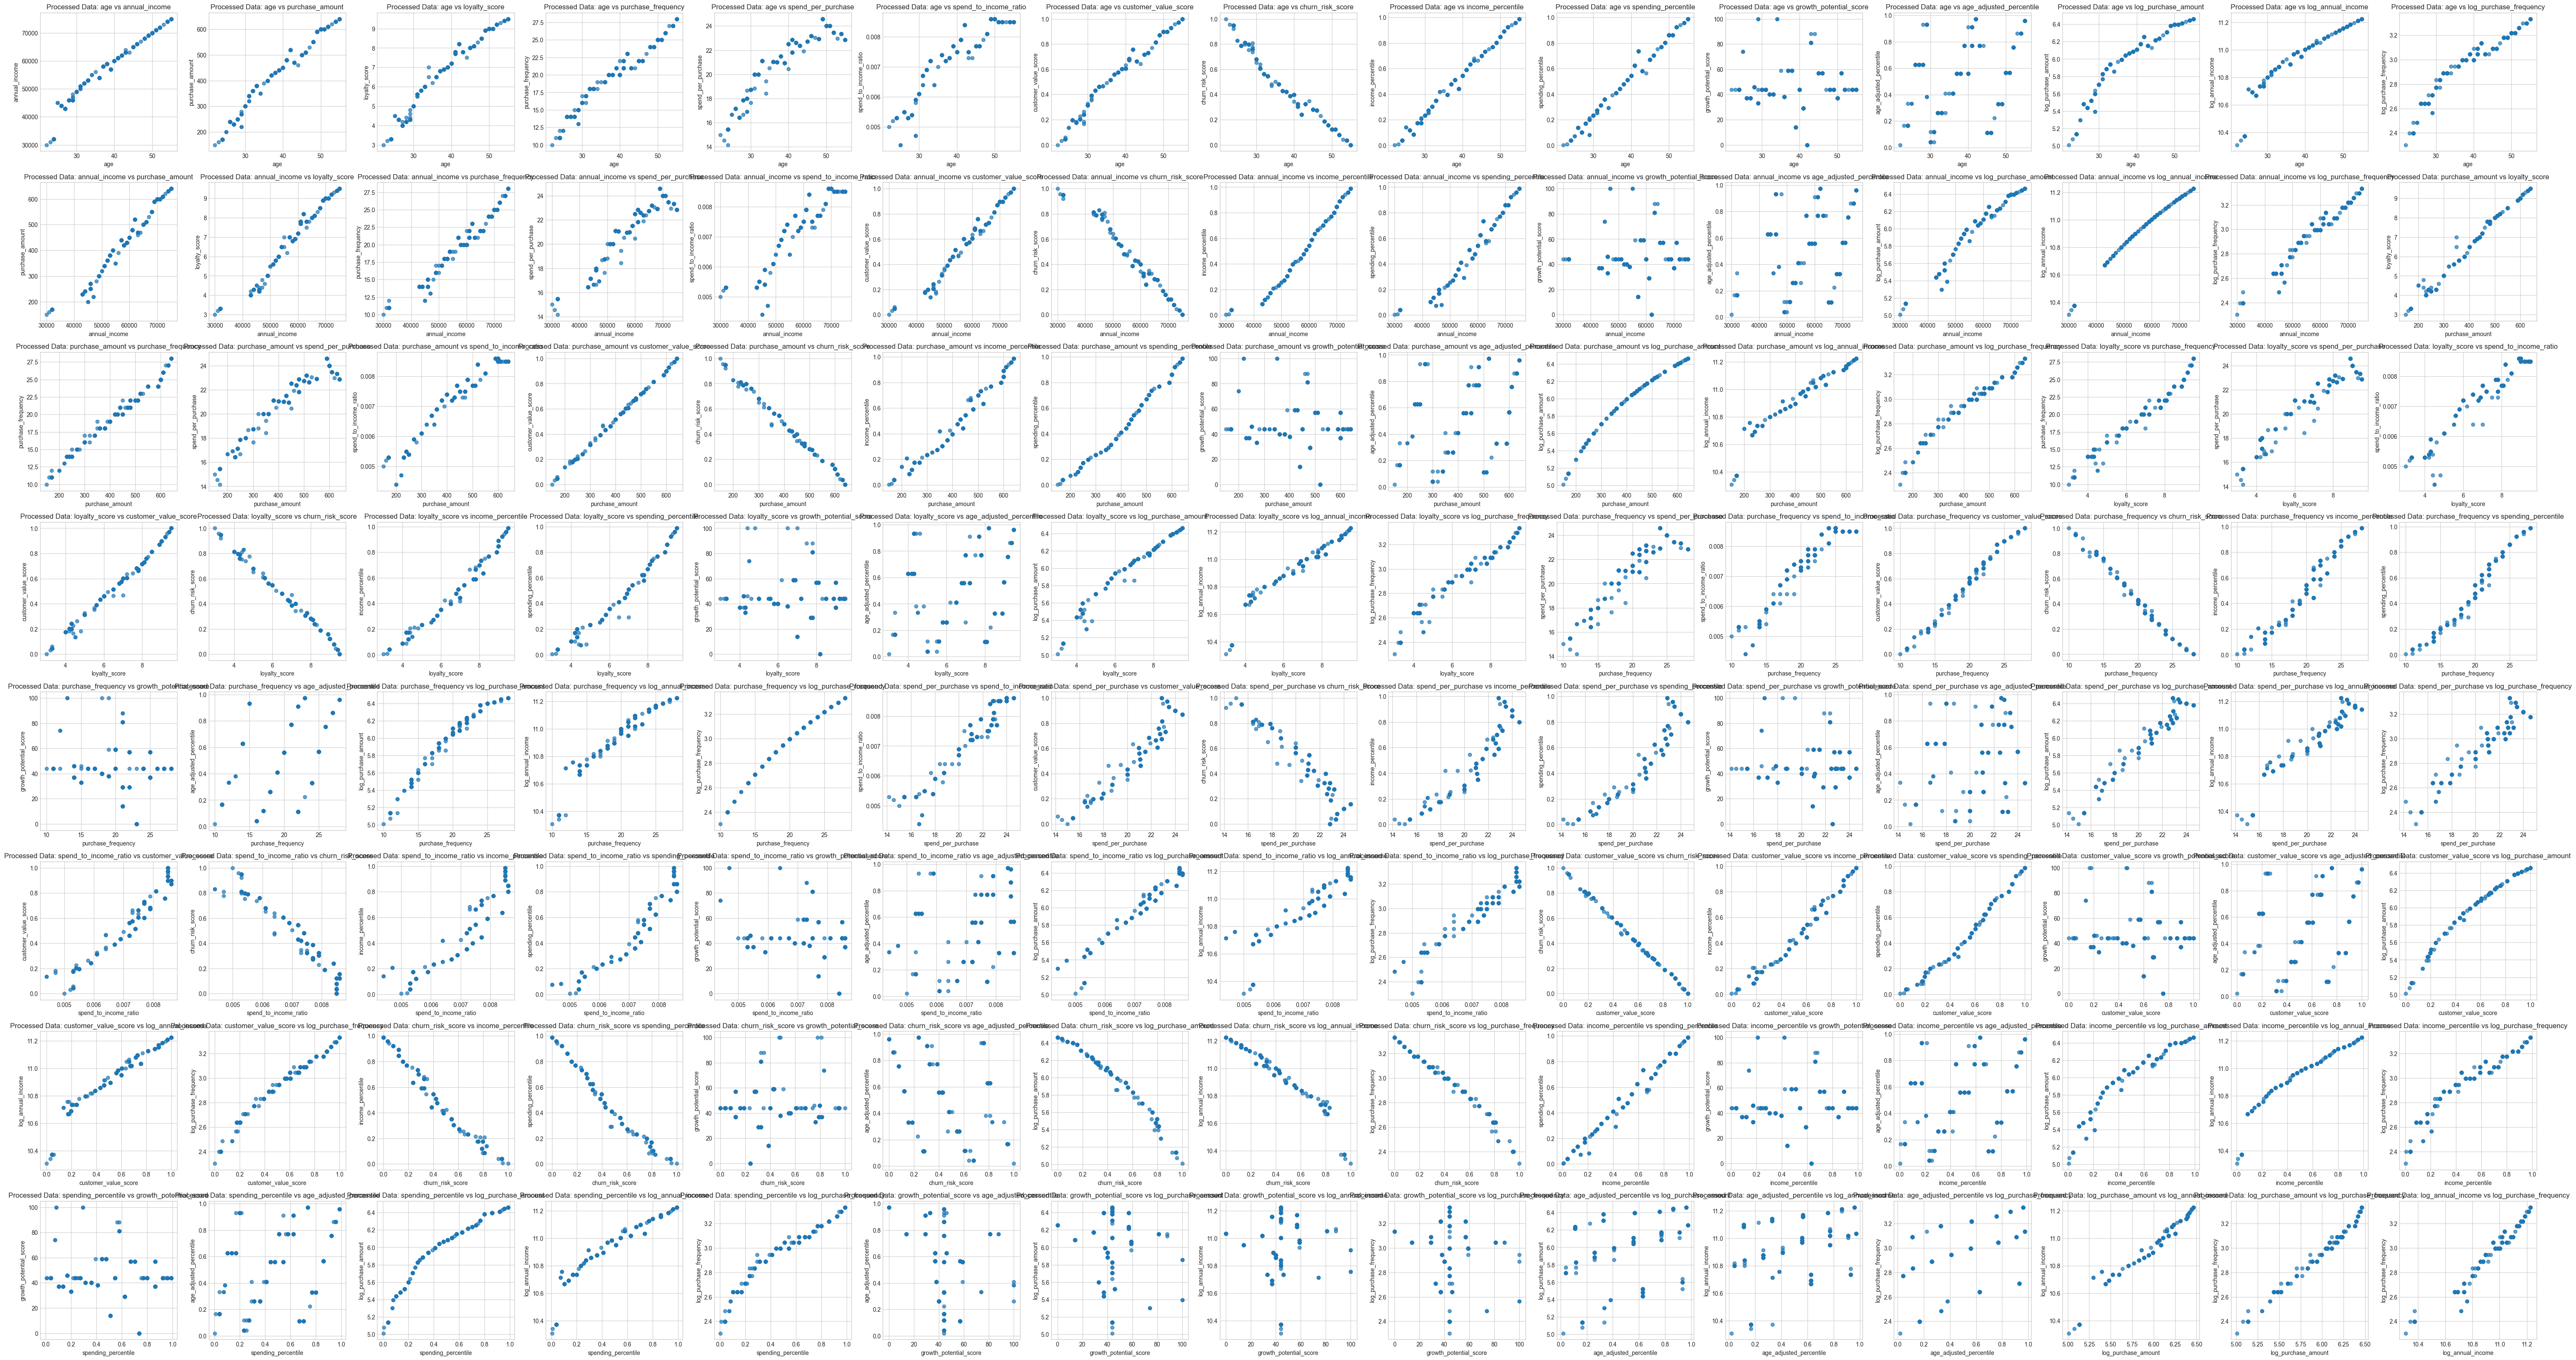

In [36]:
# Get feature names
df_feat_eng_num = df_feat_eng.select_dtypes(include=['number']).drop('user_id', axis=1)
feature_names = df_feat_eng_num.columns

# Use the helper function to plot scatter plots without coloring by cluster labels
plot_feature_pairs(df_feat_eng, feature_names, title_prefix='Processed Data: ')   